<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20RF-LSTM%20for%205%20class%20classifications%20based%20on%20WSN-DS%20dataset%20ver.2.2(15062023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid RF-LSTM for 5 class classifications based on WSN-DS dataset ver.2.2**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv")
dataset.isnull().sum()

 id                 0
 Time               0
 Is_CH              0
 who CH             0
 Dist_To_CH         0
 ADV_S              0
 ADV_R              0
 JOIN_S             0
 JOIN_R             0
 SCH_S              0
 SCH_R              0
Rank                0
 DATA_S             0
 DATA_R             0
 Data_Sent_To_BS    0
 dist_CH_To_BS      0
 send_code          0
Expaned Energy      0
Class               0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374661 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               374661 non-null  int64  
 1    Time             374661 non-null  int64  
 2    Is_CH            374661 non-null  int64  
 3    who CH           374661 non-null  int64  
 4    Dist_To_CH       374661 non-null  float64
 5    ADV_S            374661 non-null  int64  
 6    ADV_R            374661 non-null  int64  
 7    JOIN_S           374661 non-null  int64  
 8    JOIN_R           374661 non-null  int64  
 9    SCH_S            374661 non-null  int64  
 10   SCH_R            374661 non-null  int64  
 11  Rank              374661 non-null  int64  
 12   DATA_S           374661 non-null  int64  
 13   DATA_R           374661 non-null  int64  
 14   Data_Sent_To_BS  374661 non-null  int64  
 15   dist_CH_To_BS    374661 non-null  float64
 16   send_code        37

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=5)  # update to 5 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(374661, 18)
(374661, 5)


**Data preprocessing**

In [5]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Hybrid RF-LSTM for 5 class Ver.2.2**

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Extract features from RF model
train_rf_features = rf_model.predict(X_train)
test_rf_features = rf_model.predict(X_test)

# Reshape RF features for LSTM input
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, train_rf_features.shape[1]))
test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, test_rf_features.shape[1]))

Epoch 1/50
17004/17004 [==============================] - 143s 8ms/step - loss: 0.1022 - accuracy: 0.9807 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 2/50
17004/17004 [==============================] - 134s 8ms/step - loss: 0.0371 - accuracy: 0.9936 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 3/50
17004/17004 [==============================] - 130s 8ms/step - loss: 0.0309 - accuracy: 0.9948 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 4/50
17004/17004 [==============================] - 127s 7ms/step - loss: 0.0281 - accuracy: 0.9955 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 5/50
17004/17004 [==============================] - 130s 8ms/step - loss: 0.0266 - accuracy: 0.9960 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 6/50
17004/17004 [==============================] - 129s 8ms/step - loss: 0.0251 - accuracy: 0.9965 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 7/50
17004/17004 [==============================] - 132s 8ms/step - loss: 0.0240 - accuracy: 0.9968 - val_

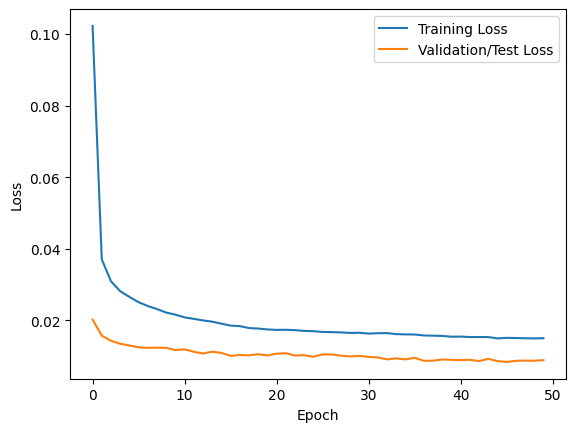

In [8]:
# Train LSTM model with RF features
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, train_rf_features.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(16, kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(5, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_model.fit(train_rf_features, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate hybrid model on test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

print(confusion_matrix(np.argmax(y_test, axis=1), test_rf_lstm_predictions))
print(classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions))

# Plot training/validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
recall = recall_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
precision = precision_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
f1score = f1_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9991325213340939
Recall: 0.9991325213340939
Precision: 0.9991326500342304
F1-Score: 0.9991322668854316
Confusion Matrix:
 [[67546    48     0    73    78]
 [    2 68133     7     0     2]
 [    0    16 68266     0     0]
 [   59     0     0 67941     9]
 [    1     0     0     0 67885]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     67745
           1       1.00      1.00      1.00     68144
           2       1.00      1.00      1.00     68282
           3       1.00      1.00      1.00     68009
           4       1.00      1.00      1.00     67886

    accuracy                           1.00    340066
   macro avg       1.00      1.00      1.00    340066
weighted avg       1.00      1.00      1.00    340066



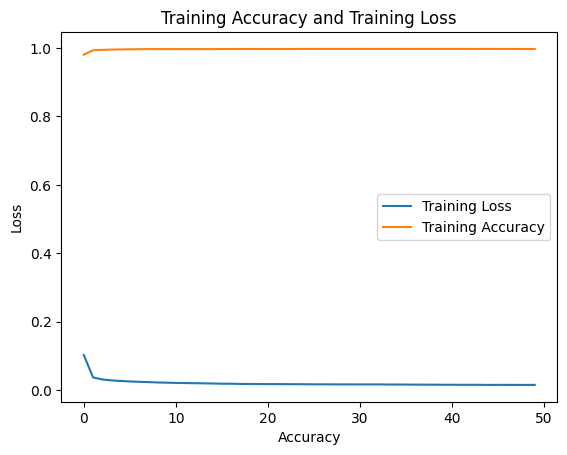

In [10]:
# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy and Training Loss')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()

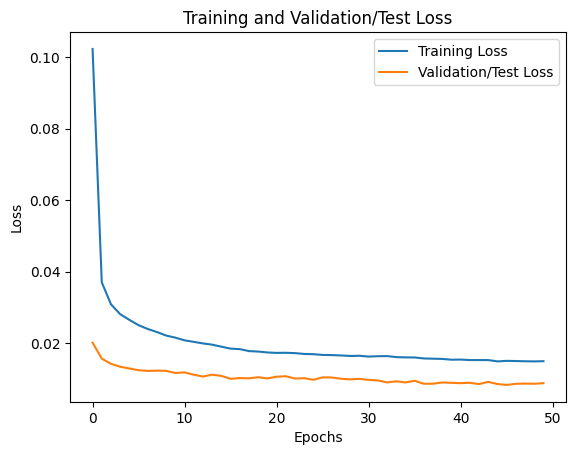

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='copper')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


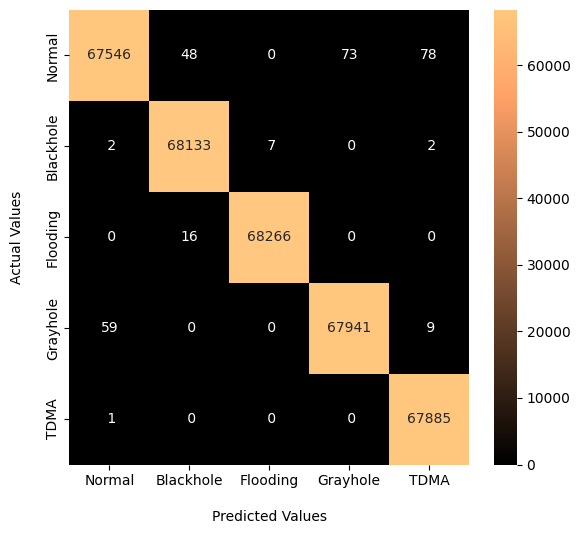

In [13]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)

In [14]:
report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(5):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates of Hybrid RF-LSTM Model:", detection_rates)

Detection rates of Hybrid RF-LSTM Model: {0: 0.9970625138386596, 1: 0.9998385771307818, 2: 0.9997656776310009, 3: 0.9990001323354262, 4: 0.9999852694222667}


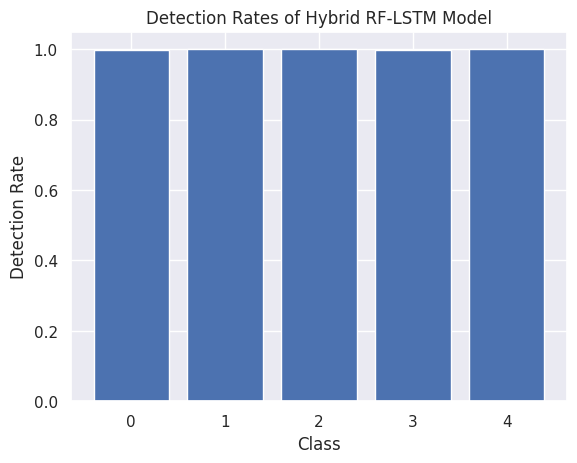

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(5):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Plot detection rates
labels = detection_rates.keys()
rates = detection_rates.values()

plt.bar(labels, rates)
plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid RF-LSTM Model')
plt.show()

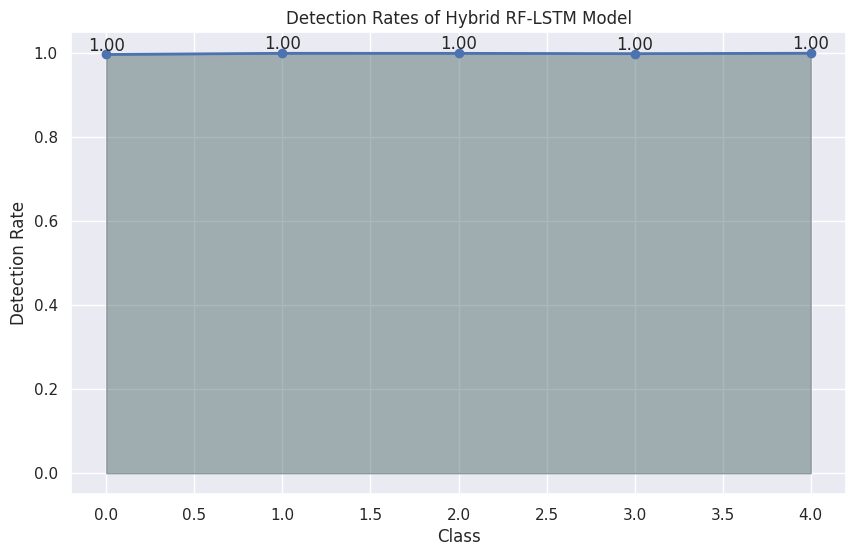

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions, output_dict=True)
detection_rates = {}
for cls in range(5):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']

# Extract the class labels and detection rates
labels = list(detection_rates.keys())
rates = list(detection_rates.values())

# Plot the line graph with filled area and labels
plt.figure(figsize=(10, 6))
plt.plot(labels, rates, marker='o', linestyle='-', linewidth=2)
plt.fill_between(labels, rates, color='darkslategrey', alpha=0.4)

# Add labels to each data point
for i in range(len(labels)):
    plt.text(labels[i], rates[i], "{:.2f}".format(rates[i]), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Detection Rate')
plt.title('Detection Rates of Hybrid RF-LSTM Model')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

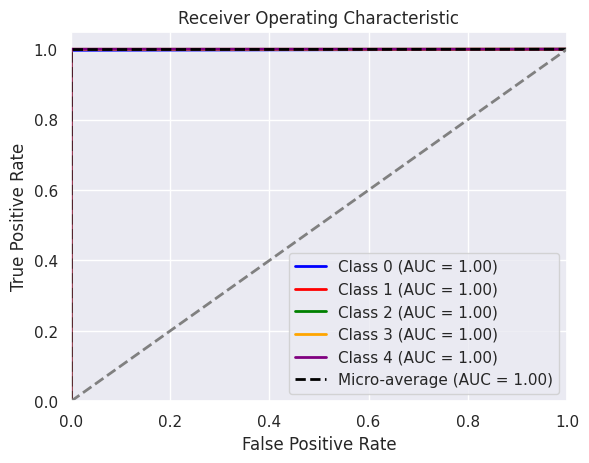

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import np_utils

# Convert y_test and test_rf_lstm_predictions to one-hot encoded format
y_test_onehot = np_utils.to_categorical(np.argmax(y_test, axis=1))
test_rf_lstm_predictions_onehot = np_utils.to_categorical(test_rf_lstm_predictions, num_classes=5)  # Convert to one-hot encoded format with 5 classes

# Compute the AUC and ROC curves for each class
n_classes = y_test_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], test_rf_lstm_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), test_rf_lstm_predictions_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust the colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2, linestyle='--', label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix and classification report
##print(confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))
##print(classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(test_rf_features_onehot, axis=1)))